In [1]:
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import math
import statistics as stat
import random

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import ticker, patches

lblue  = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred   = (177/255,4/255,14/255)


plt.rcParams.update({
    'lines.linewidth' : 1.,
    'lines.markersize' : 5,
    'font.size': 10,
    "text.usetex": True,
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'],
    'text.latex.preamble' : r'\usepackage{amsmath,amsfonts}',
    'axes.linewidth' : .75})

In [2]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

In [3]:
n = 500
eta = 1/n**.5
K = int(1/eta)
print(K, eta)
len(np.arange(0, 1+eta, eta)), K
#np.array_split(np.arange(n), 5)

22 0.044721359549995794


(24, 22)

# Type I error analysis

In [4]:
%%time
nrep = 1000#100000

gamma_seq = 10**np.linspace(-1, 1, 7) #[.1, 1, 10]
n = 500
#eta = 1/(n**0.75)
eta = 1/n**.5
# K = int(1/eta)


def effect_on_validity():
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))
        
    for l in tqdm(range(nrep)):
#         if l%10000==0: print(l/10000)
        Z = np.random.normal(0,1,n)
        Y = np.random.normal(0,1,n)
        eta = 1/(n**0.75)
        K = int(1/eta)

        matchings = {}
        matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
        matchings['cb']   = cross_bin_matching(Y, Z, K)

        for gamma in gamma_seq:
            for setting in range(2):
                if setting==0:
                    mu=gamma*Z
                elif setting==1:
                    mu=norm.cdf(gamma*Z)
                X = mu + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(setting, label)][gamma][l] = SCINT_test(X,Y,M)
    return(pvalues)

results = effect_on_validity()

100%|██████████████████| 1000/1000 [00:13<00:00, 72.20it/s]

CPU times: user 13.4 s, sys: 429 ms, total: 13.9 s
Wall time: 13.9 s


In [31]:
titles

['$\\mathbb E[X|Z]=$ $\\gamma Z$', '$\\mathbb E[X|Z]=$ $\\Phi(\\gamma Z)$']

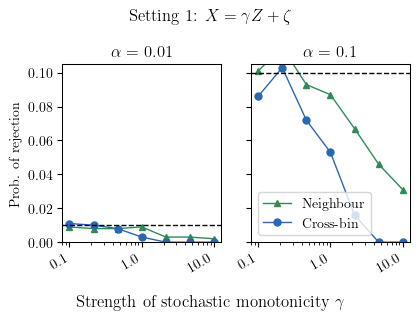

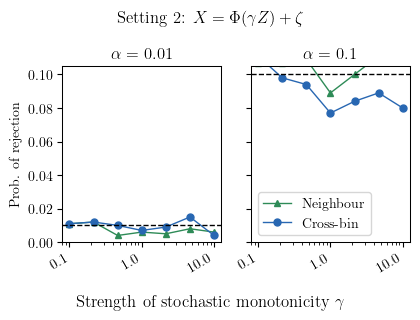

In [6]:
# nrep = 1000000
for setting in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4.3, 3.2), # 4.875
                             sharex=True, sharey=True)

    alphas = [.01, .1]
    col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.1$']]
    #titles = [r'$\mathbb E[X|Z]=$ {}'.format(setting_name) for setting_name in ['$\\gamma Z$', '$\Phi(\\gamma Z)$']]
    titles = [r'$X = ' + setting_name + ' + \\zeta$ ' for setting_name in ['\\gamma Z', '\Phi(\\gamma Z)']]

    methods = [('nbhd', "Neighbour", sgreen, '^'), 
               ('cb', "Cross-bin", lblue, 'o'), 
    #            ('sb', "Same bin", cred), 
              ]
    axes[0].set_ylim([0, .105])
    for col in range(2):
        axes[col].set_title(col_titles[col])

        alpha = alphas[col]
#         for row, title in enumerate(row_titles):
        for nm, name, color, shape in methods:
#             print(len(results[(setting,nm)][.1] < alpha))
            axes[col].plot(gamma_seq, [np.mean(results[(setting,nm)][gamma] < alpha) for gamma in gamma_seq], marker=shape, 
                               linestyle='solid', c=color, label=name)
        axes[col].axhline(y=alpha,c=(0,0,0),linestyle='--')


    lines = [] 
    labels = [] 
    Line, Label = axes[0].get_legend_handles_labels() 
    lines.extend(Line) 
    labels.extend(Label) 

    axes[0].set_xscale('log')#, base=2)
    axes[0].set_xticks([.1, 1, 10], [.1, 1, 10], rotation='vertical')
    axes[0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axes[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
    for i in range(2):
        labels = axes[i].get_xticklabels()
        plt.setp(labels, rotation=30, horizontalalignment='right')


    fig.suptitle('Setting %d: ' %(setting+1) + titles[setting], y=.97)
    fig.supxlabel('Strength of stochastic monotonicity $\\gamma$', y=.03)
    # fig.supylabel('Type I error')
    axes[0].set_ylabel('Prob. of rejection')
    # fig.legend(lines, labels, loc='right')
    axes[1].legend(loc='lower left')
    plt.tight_layout()
    #fig.savefig('figures/validity_curve_log_tall-nrep=%d-setting=%d.pdf' % (nrep, setting ), bbox_inches='tight')
    plt.show()

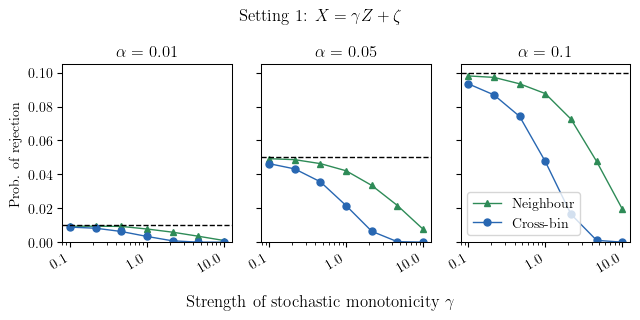

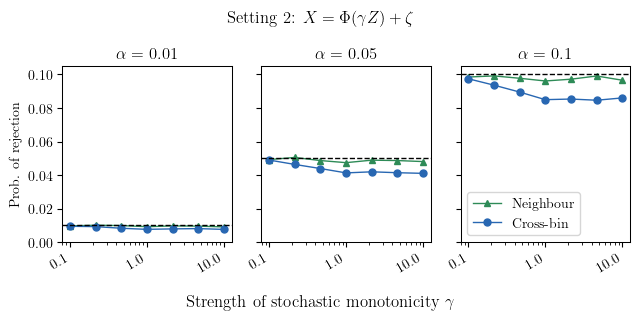

In [19]:
# nrep = 1000000
for setting in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 3.2), # 4.875
                             sharex=True, sharey=True)

    alphas = [.01, .05, .1]
    col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
    #titles = [r'$\mathbb E[X|Z]=$ {}'.format(setting_name) for setting_name in ['$\\gamma Z$', '$\Phi(\\gamma Z)$']]
    titles = [r'$X = ' + setting_name + ' + \\zeta$ ' for setting_name in ['\\gamma Z', '\Phi(\\gamma Z)']]

    methods = [('nbhd', "Neighbour", sgreen, '^'), 
               ('cb', "Cross-bin", lblue, 'o'), 
    #            ('sb', "Same bin", cred), 
              ]
    axes[0].set_ylim([0, .105])
    for col in range(3):
        axes[col].set_title(col_titles[col])

        alpha = alphas[col]
#         for row, title in enumerate(row_titles):
        for nm, name, color, shape in methods:
#             print(len(results[(setting,nm)][.1] < alpha))
            axes[col].plot(gamma_seq, [np.mean(results[(setting,nm)][gamma] < alpha) for gamma in gamma_seq], marker=shape, 
                               linestyle='solid', c=color, label=name)
        axes[col].axhline(y=alpha,c=(0,0,0),linestyle='--')


    lines = [] 
    labels = [] 
    Line, Label = axes[0].get_legend_handles_labels() 
    lines.extend(Line) 
    labels.extend(Label) 

    axes[0].set_xscale('log')#, base=2)
    axes[0].set_xticks([.1, 1, 10], [.1, 1, 10], rotation='vertical')
    axes[0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axes[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
    for i in range(3):
        labels = axes[i].get_xticklabels()
        plt.setp(labels, rotation=30, horizontalalignment='right')


    fig.suptitle('Setting %d: ' %(setting+1) + titles[setting], y=.97)
    fig.supxlabel('Strength of stochastic monotonicity $\\gamma$', y=.03)
    # fig.supylabel('Type I error')
    axes[0].set_ylabel('Prob. of rejection')
    # fig.legend(lines, labels, loc='right')
    axes[2].legend(loc='lower left')
    plt.tight_layout()
    #fig.savefig('figures/validity_curve_log_tall-nrep=%d-setting=%d.pdf' % (nrep, setting ), bbox_inches='tight')
    plt.show()

# Power analysis

In [7]:
def sim_YZ(n, setting):
    if setting == 1:
        rho = 0
    elif setting == 2:
        rho = .5
    elif setting == 3:
        rho = -.5

    cov = (1-rho)*np.eye(2) + rho*np.ones((2,2))
    Y, Z = np.random.multivariate_normal([0,0], cov, size=n).T
        
    return Y, Z


In [ ]:
%%time
nrep= 1000#10000
alpha=0.1 

nseq=np.array([500, 1000, 5000, 10000])

def power_analysis_sim(setting):
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))
    power   = defaultdict(lambda : defaultdict(float))
    for n in nseq:
        eta = 1/(n**0.5) #1/(n**0.75)

        
        for l in tqdm(range(nrep)):
            Y,Z = sim_YZ(n, setting)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
            #matchings['sb']   = same_bin_matching(Y, Z, eta)
            K = int(1/eta)
            matchings['cb']   = cross_bin_matching(Y, Z, K)
            
            beta = 1/(n**(1/3))
            for gamma in [1,10]: 
                X = gamma*Z + beta*Y + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(gamma, label)][n][l] = SCINT_test(X,Y,M)
        for k in pvalues:
            power[k][n] = np.mean(pvalues[k][n] < alpha)
    return(pvalues, power)

power_results = []
_, power1 = power_analysis_sim(1)
power_results.append(power1)

_, power2 = power_analysis_sim(2)
power_results.append(power2)

_, power3 = power_analysis_sim(3)
power_results.append(power3)



 30%|█████▊             | 303/1000 [00:10<00:23, 29.31it/s]

In [38]:
nrep=10000

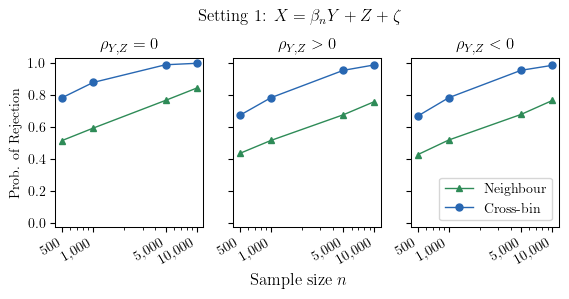

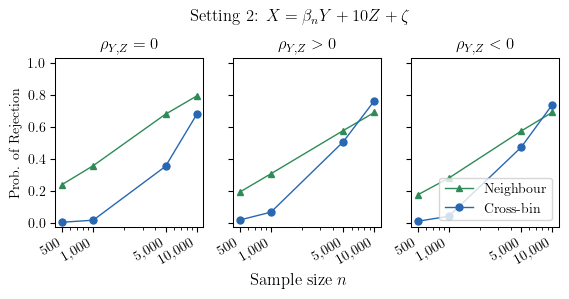

In [41]:
titles = ['$X = \\beta_n Y + Z + \\zeta$', '$X = \\beta_n Y + 10 Z + \\zeta$']
for ind, gamma in enumerate([1,10]):
    from matplotlib.transforms import offset_copy

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2.2), 
                             sharex=True, sharey='row')

    col_titles = [r'$\rho_{Y,Z}' + col_name for col_name in ['=0$','>0$','<0$']]

    methods = [('nbhd', "Neighbour", sgreen, '^'), 
               ('cb', "Cross-bin", lblue, 'o'), 
              ]

    for col in range(3):
        axes[col].set_title(col_titles[col])
        for nm, name, color, shape in methods:
            axes[col].semilogx(nseq, power_results[col][(gamma, nm)].values(), marker=shape, 
                               linestyle='solid', c=color, label=name)

    axes[0].set_ylabel('Prob. of Rejection')

    lines = [] 
    labels = [] 
    Line, Label = axes[0].get_legend_handles_labels() 
    lines.extend(Line) 
    labels.extend(Label) 

    # axes[0,0].set_xscale('log')#, base=2)
    axes[0].set_xticks(nseq, nseq, rotation='vertical')
    axes[0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axes[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    for i in range(3):
        labels = axes[i].get_xticklabels()
        plt.setp(labels, rotation=30, horizontalalignment='right')
    # axes[0,0].set_xticks(nseq, nseq, rotation=)
    # axes[0,0]..tick_params(axis='x', labelrotation=90)

    fig.supxlabel('Sample size $n$', y=-.17)
    fig.suptitle('Setting %d: ' % (ind+1)+ titles[ind], y=1.1)
    
    axes[0].set_ylim([-.03,1.03])

    axes[2].legend(loc='lower right') 
    #fig.savefig('figures/power-nrep=%d-gamma=%d.pdf' % (nrep, gamma), bbox_inches='tight')
    plt.show()

In [25]:
power_results[0][1].values()

dict_values([0.935, 0.971, 0.999, 1.0])

In [20]:
from scipy.linalg import sqrtm

In [49]:
dd = 1
pp = 2*dd
S = np.eye(pp)
rho = .54
for j in range(dd):
    S[j,j+dd]=rho
    S[j+dd,j]=rho
sqrtm(S), np.array([[np.sqrt((1+np.sqrt(1-rho**2))/2), np.sqrt((1-np.sqrt(1-rho**2))/2)]])

(array([[0.95960018, 0.28136718],
        [0.28136718, 0.95960018]]),
 array([[0.95960018, 0.28136718]]))

\begin{align*}
K &= \begin{bmatrix}
a & b \\ 
b & a
\end{bmatrix} \\
K^2 &= \begin{bmatrix}
a^2+b^2 & 2ab \\ 
2ab & a^2+b^2
\end{bmatrix}
= \begin{bmatrix}
1 & \rho \\ 
\rho & 1
\end{bmatrix}
\end{align*}

$0=4A^2-4A+rho^2$

$A = \frac{1\pm \sqrt{1-\rho^2}}{2}$

$b = \rho/(2a)$

0.5310885545960922